# Programming Assignment - FakeFinder: Upgrading the Expedition with Transfer Learning

Welcome back, AI Explorer! In your first expedition, you successfully built a **FakeFinder** from the ground up, navigating the complex hyperparameter landscape with Optuna to engineer a custom CNN architecture. You learned the fundamental principles of model construction and optimization, an essential skill for any deep learning practitioner.

Now, it's time to upgrade your toolkit for the next leg of your journey. In the real world, explorers don't always build their vehicles from scratch; they often retrofit a powerful, pre-existing engine to achieve superior performance with greater efficiency. That is your mission in this assignment: to leverage the power of **transfer learning**.

You will harness the knowledge of a veteran model, **MobileNetV3-Large**, which has already been trained on the vast ImageNet dataset. By adapting this pre-trained model to our specific `AIvsReal` dataset, you will see a dramatic improvement in performance and speed.

Throughout this upgraded expedition, you will:

* Prepare your familiar image dataset with transformation pipelines optimized for pre-trained models.
* Understand the core principles of transfer learning and its pivotal role in modern computer vision.
* Load a powerful pre-trained model and adapt it for a new task using **feature extraction**.
* Freeze the convolutional base and replace the final classifier layer to specialize the model for fake image detection.
* Train your adapted model and compare its remarkable results to the custom model from your first assignment.

Get ready to see how leveraging pre-trained wisdom can accelerate your path to building highly effective, state of the art models.

## Table of Contents
- [Imports](#0)
- [1 - Preparing for the Next Expedition: A Quick Reconnaissance](#1)
    - [1.1 - Scouting the Archives: Loading Data with ImageFolder](#1-1)
        - **[Exercise 1 - create_dataset_splits](#ex-1)**    
    - [1.2 - Specialized Augmentations: Protocols for Training and Validation](#1-2)
        - **[Exercise 2 - define_transformations](#ex-2)**
    - [1.3 - Preparing the Data Launchpad: Applying Transformations and Batching Data](#1-3)
        - **[Exercise 3 - create_data_loaders](#ex-3)**    
- [2 - Advanced Expedition: Leveraging Pre-trained Model Wisdom](#2)
    - [2.1 - Selecting Your Champion: Introducing MobileNetV3-Large](#2-1)
        - **[Exercise 4.1 - load_mobilenetv3_model](#ex-41)**
    - [2.2 - Tailoring Your Champion: Adapting MobileNetV3 for Fake Detection](#2-2)
        - **[Exercise 4.2 - update_model_last_layer](#ex-42)**
- [3 - Final Expedition: Training and Evaluating Your Adapted Champion](#3)
    - [3.1 - Setting the Launchpad: Preparing DataLoaders and the Adapted Model](#3-1)
    - [3.2 - Training the Adapted Model](#3-2)
    - [3.3 - Performance Review: Visualizing Predictions](#3-3)

## Imports

In [2]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as tv_models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import helper_utils


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(f"Using Device: {DEVICE}")

Using Device: mps


<a name='1'></a>
## 1 - Preparing for the Next Expedition: A Quick Reconnaissance

This assignment continues from the previous one, using the same curated collection of images from the [AI-Generated Images vs Real Images](https://www.kaggle.com/datasets/tristanzhang32/ai-generated-images-vs-real-images) dataset. 

As a reminder, this dataset is a sample from a larger collection of 60,000 images. Half are generated by advanced AI models (Stable Diffusion, MidJourney, and DALL·E), and the other half are genuine images from sources like Pexels and Unsplash. You will work with the same carefully selected subset of **5,000 images for training** and **1,000 for testing/validation**.

The data organization is the same as before. Images are sorted into `train` and `test` folders, each containing `real` and `fake` subdirectories. This logical structure is fundamental to understand, as it directly influences how you will load the data for the upcoming tasks.

Here’s a reminder of the data layout:

```
./AIvsReal_sampled/
└───train/
|   ├───fake/
|   │   ├───0046.jpg
|   │   └───...
|   └───real/
|       ├───0046.jpg
|       └───...
└───test/
    ├───fake/
    │   ├───0046.jpg
    │   └───...
    └───real/
        ├───0046.jpg
        └───...
```

* Run the next two cells to define the path to the dataset and view some samples from the training folder.

In [4]:
# Load the dataset path
dataset_path = "./AIvsReal_sampled"  

# Analyzes the dataset splits at the given path and prints a count of images for each class.
helper_utils.dataset_images_per_class(dataset_path)

Analyzing dataset at: ./AIvsReal_sampled

— Train —
Fake: 2500 images
Real: 2500 images

— Test —
Fake: 500 images
Real: 500 images



**Note**: For the remainder of this assignment, you will use the `test` directory as your **validation set**.

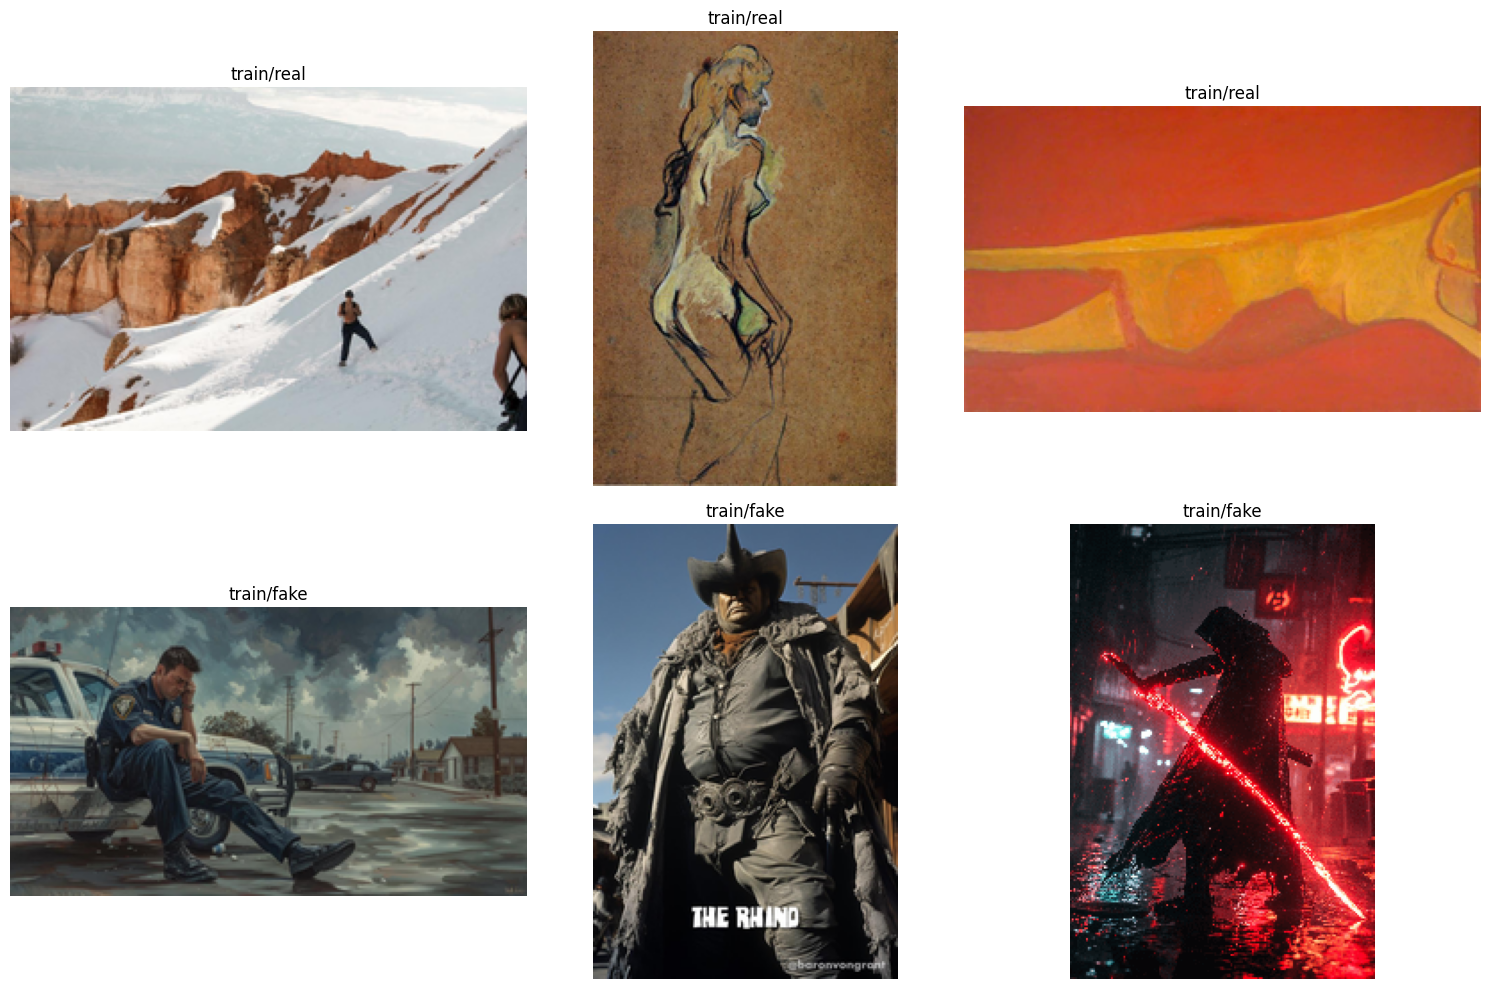

In [5]:
# Randomly select and display a grid of sample images from the 'train' folder.
helper_utils.display_train_images(dataset_path)

<a name='1-1'></a>
### 1.1 - Scouting the Archives: Loading Data with ImageFolder

Now that you've reviewed the dataset, your next objective is to load the images into a structure that PyTorch can use for training. For datasets that are neatly organized into subdirectories for each class, such as your `AIvsReal_sampled` data, `ImageFolder` is an exceptionally convenient and standard tool.

This tool works by automatically inferring class labels from the names of the subdirectories. It expects your data to be arranged such that `dataset_path/class_name/image_name.jpg` would be an image belonging to `class_name`. This feature aligns perfectly with your dataset's organized structure, saving you significant preparation time.

A pivotal advantage of `ImageFolder` is its `transform` attribute. This allows you to apply a sequence of image transformations, giving you precise control over how your data is prepared. You have the flexibility to set these transformations when you first load the data or apply them later. This adaptability ensures your data loading pipeline is highly effective and reusable for future projects.

<a name='ex-1'></a>
### Exercise 1 - create_dataset_splits

Your first exercise is to implement the `create_dataset_splits` function. This function will load your image data from the disk and create two distinct PyTorch `Dataset` objects.

**Your Task**:

* Use the [ImageFolder](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) class to create a dataset object for your training data and another for your validation data.
* The paths for the training and validation directories (`train_path` and `val_path`) have already been defined for you. You'll need to pass the correct path to each `ImageFolder` instance.
* The function should return the two datasets you create: `train_dataset` and `val_dataset`.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you need some help, here is a more detailed guide.

You need to create two instances of the `ImageFolder` class. The main argument you need to provide is `root`, which tells `ImageFolder` where to find the images.

* The first line for the training dataset will look like this:
    > `train_dataset = ImageFolder(root=train_path)`
* Now, apply the same logic to create the `val_dataset`. Make sure you use the `val_path` variable for its `root`.

</details>

In [6]:
# GRADED FUNCTION: create_dataset_splits

def create_dataset_splits(data_path):
    """
    Creates training and validation datasets from a directory structure using ImageFolder.

    Args:
        data_path (str): The root path to the dataset directory, which should
                         contain 'train' and 'validation/test' subdirectories.

    Returns:
        tuple: A tuple containing the train_dataset and validation_dataset
               (train_dataset, validation_dataset).
    """

    # Construct the full path to the training data directory.
    train_path = data_path + "/train"
    # Construct the full path to the validation data directory.
    val_path = data_path + "/test"

    ### START CODE HERE ###
    
    # Create the train dataset using ImageFolder
    train_dataset = ImageFolder(
        # Set the root to train dataset path
        root=train_path,
    ) 

    # Create the validation dataset using ImageFolder
    val_dataset = ImageFolder(
        # Set the root to validation dataset path
        root=val_path,
    ) 

    ### END CODE HERE ###

    return train_dataset, val_dataset

In [7]:
# Verify that the function loads the datasets
temp_train, temp_val = create_dataset_splits(dataset_path)

print("--- Training Dataset ---")
print(temp_train)
print("\n--- Validation Dataset ---")
print(temp_val)

--- Training Dataset ---
Dataset ImageFolder
    Number of datapoints: 5000
    Root location: ./AIvsReal_sampled/train

--- Validation Dataset ---
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: ./AIvsReal_sampled/test


#### Expected Output:
```
--- Training Dataset ---
Dataset ImageFolder
    Number of datapoints: 5000
    Root location: ../AIvsReal_sampled/train

--- Validation Dataset ---
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: ../AIvsReal_sampled/test
```    

<a name='1-2'></a>
### 1.2 - Specialized Augmentations: Protocols for Training and Validation

Now it's time to define the transformations that will prepare your images for the neural network. These preprocessing steps are pivotal for standardizing your data and for augmenting the training set to make your model more robust.

When using pre-trained architectures as you will later, it's standard practice to apply *different* sets of transformations to your training and validation datasets. When leveraging a pre-trained model, it is **essential** that the core transformations applied to both your training and validation data are identical to the ones used to train the original model. This is particularly important for resizing the images and using the same normalization values (mean and standard deviation). While data augmentation techniques can vary between your training and validation data, these fundamental steps ensure your data is processed in a way the pre-trained model already understands.

* Before jumping into the transformations, you'll first define the standard normalization values from the ImageNet dataset, on which many pre-trained models were trained.

In [8]:
# Define the standard mean values for the ImageNet dataset
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])

# Define the standard standard deviation values for the ImageNet dataset
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

<a name='ex-2'></a>
### Exercise 2 - define_transformations

In this exercise, you'll implement the `define_transformations` function to create two distinct image transformation pipelines: one for augmenting the training data and another for preparing the validation data.

**Your Task**:

* **For the `train_transform` pipeline:**
    * You need to chain together a series of transformations using [transforms.Compose](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html).
    * This pipeline should include operations for:
        *  [Random resizing](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html).
        *  [Random horizontal flipping](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html).
        *  [Color adjustments](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html) to augment the data.
        *  [Tensor conversion](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html).
        *  [Normalization](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html).
>
* **For the `val_transform` pipeline:**
    * Create a second `transforms.Compose` pipeline.
    * This one will be simpler and should only include the essential steps:
        * [Resizing](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) the image.
        * [Tensor conversion](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html).
        * [Normalization](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html).
> 
* Both pipelines should use the `mean` and `std` values passed into the function for normalization.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you're looking for a more detailed guide, follow these steps.

**For `train_transform`:**

Your `transforms.Compose` list should contain five transformation steps in this order:
1.  Add the `RandomResizedCrop` transform, setting the output size to `(224, 224)`.
2.  Add the `RandomHorizontalFlip` transform.
3.  Add the `ColorJitter` transform, setting `brightness` and `contrast` to `0.2`.
4.  Add the `ToTensor` transform to convert images to tensors.
5.  Add the `Normalize` transform, using the `mean` and `std` variables from the function's arguments.

**For `val_transform`:**

Your `transforms.Compose` list for validation is simpler and has three steps:
1.  The first transform is for resizing:
    > `transforms.Resize((224, 224))`
2.  Next, add the `ToTensor` transform.
3.  Finally, add the `Normalize` transform, again using the `mean` and `std` variables.

</details>

In [9]:
# GRADED FUNCTION: define_transformations

def define_transformations(mean=imagenet_mean, std=imagenet_std):
    """
    Defines separate series of image transformations for training and validation datasets.

    Args:
        mean (list or tuple): The mean values (for each channel, e.g., RGB) calculated from ImageNet.
        std (list or tuple): The standard deviation values (for each channel) calculated from ImageNet.

    Returns:
        tuple: A tuple containing two `torchvision.transforms.Compose` objects:
               - The first for training transformations.
               - The second for validation transformations.
    """

    ### START CODE HERE ###

    # Create a Compose object to chain multiple transformations together for the training set
    
    # Initialize 'train_transform' using transforms.Compose to apply a sequence of transforms
    train_transform = transforms.Compose([
        # Randomly resize and crop the input image to 224x224 pixels
        transforms.RandomResizedCrop(size=(224,224)),

        # Apply a random horizontal flip to the image for data augmentation
        transforms.RandomHorizontalFlip(),

        # Randomly change the brightness and contrast of the image for data augmentation
        # Set `brightness=0.2` and `contrast=0.2`
        transforms.ColorJitter(brightness=0.2, contrast=0.2),

        # Convert the PIL Image to a PyTorch Tensor
        transforms.ToTensor(),

        # Normalize the tensor image with the provided 'mean' and 'std' to normalize the tensor
        transforms.Normalize(mean=mean, std=std),
    ]) 

    # Create a Compose object to chain multiple transformations together for the validation set
    
    # Initialize 'val_transform' using transforms.Compose to apply a sequence of transforms
    val_transform = transforms.Compose([
        # Resize the input image to to 224x224 pixels
        transforms.Resize(size=(224,224)),

        # Convert the PIL Image to a PyTorch Tensor
        transforms.ToTensor(),

        # Normalize the tensor image with the provided 'mean' and 'std' to normalize the tensor
        transforms.Normalize(mean=mean, std=std),
    ]) 

    ### END CODE HERE ###

    return train_transform, val_transform

In [10]:
# Create the composed transformations
combined_transformations = define_transformations()

# Print the composed transformations to verify the sequence of operations
print("Augmented Training Transformations:\n")
print(combined_transformations[0])
print("\nValidation Transformations:\n")
print(combined_transformations[1])

Augmented Training Transformations:

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Validation Transformations:

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


#### Expected Output:
```
Augmented Training Transformations:

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Validation Transformations:

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
```

<a name='1-3'></a>
### 1.3 - Preparing the Data Launchpad: Applying Transformations and Batching Data

You have now handled the creation of your training and validation dataset objects and separately defined the transformation pipelines for each. A powerful feature of the `ImageFolder` objects is their built-in `.transform` attribute. You'll now apply your defined transformations by assigning each pipeline to its respective dataset. This provides a clean and modular way to prepare each data subset for its specific purpose. After this, you'll use `DataLoader` to create batched and shuffled data loaders for your training and validation data, which is an essential step to prepare it for training.

<a name='ex-3'></a>
### Exercise 3 - create_data_loaders

Your task is to implement the `create_data_loaders` function. This function brings everything together by applying the transformations to your datasets and then wrapping them in `DataLoader` objects to prepare them for training.

**Your Task**:

* **Retrieve Transformations**:
    * Call the `define_transformations()` function you implemented earlier to get the `train_transform` and `val_transform` pipelines.
>
* **Apply Transformations**:
    * Assign the `train_transform` to the `.transform` attribute of the input `trainset`.
    * Assign the `val_transform` to the `.transform` attribute of the input `valset`.
>
* **Create DataLoaders**:
    * Instantiate a [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training set. Remember to shuffle the training data.
    * Instantiate a second `DataLoader` for the validation set. This one should not be shuffled.
>
* Both `DataLoader` instances should use the `batch_size` provided to the function.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you need a more detailed guide, follow these steps.

1.  **Get the transformations**: This is a single function call with two return values.
    > `train_transform, val_transform = define_transformations()`

2.  **Apply the transformations**: You just need to assign the transform objects to the correct dataset attribute. The first one is:
    > `trainset.transform = train_transform`
    > Now do the same for the `valset` using the `val_transform`.

3.  **Create the training `DataLoader`**: The `DataLoader` needs the dataset, `batch_size`, and shuffle status.
    > `train_loader = create a new DataLoader using (the trainset, the function's batch_size, and set shuffle to True)`

4.  **Create the validation `DataLoader`**: This is almost identical to the training loader.
    > `val_loader = create a new DataLoader using (the valset, the function's batch_size, and set shuffle to False)`

</details>

In [11]:
# GRADED FUNCTION: create_data_loaders

def create_data_loaders(trainset, valset, batch_size):
    """
    Creates DataLoader instances for training and validation datasets with respective transformations.

    Args:
        trainset (torch.utils.data.Dataset): The training dataset.
        valset (torch.utils.data.Dataset): The validation dataset.
        batch_size (int): The number of samples to load in each batch.

    Returns:
        tuple: A tuple containing:
            - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
            - val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
            - trainset (torch.utils.data.Dataset): The original training dataset with transformations now applied.
            - valset (torch.utils.data.Dataset): The original validation dataset with transformations now applied.
    """
    
    ### START CODE HERE ###
    
    # Define separate transformations for the training and validation datasets
    # Use define_transformations() to get train_transform and val_transform
    train_transform, val_transform = define_transformations()
    
    # Apply the train transformations directly to the train dataset by setting the .transform attribute
    trainset.transform = train_transform
    # Apply the val transformations directly to the val dataset by setting the .transform attribute
    valset.transform = val_transform
    
    # Create a DataLoader for the training dataset
    # Use the transformed train dataset
    # Set batch_size to the input batch_size
    # Set shuffle=True
    train_loader = DataLoader(
        dataset=trainset,
        batch_size=batch_size,
        shuffle=True
    )
    
    # Create a DataLoader for the validation dataset
    # Use the transformed validation dataset
    # Set batch_size to the input batch_size
    # Set shuffle=False
    val_loader = DataLoader(
        dataset=valset,
        batch_size=batch_size,
        shuffle=False
    )
    
    ### END CODE HERE ###
    
    return train_loader, val_loader, trainset, valset

In [12]:
dataloaders = create_data_loaders(temp_train, temp_val, batch_size=16)

print("--- Train Loader ---")
helper_utils.display_data_loader_contents(dataloaders[0])
print("\n--- Val Loader ---")
helper_utils.display_data_loader_contents(dataloaders[1])

--- Train Loader ---
Length: 313
--- Batch 1 ---
Data shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])

--- Val Loader ---
Length: 63
--- Batch 1 ---
Data shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


#### Expected Output:
```
--- Train Loader ---
Length: 313
--- Batch 1 ---
Data shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])

--- Val Loader ---
Length: 63
--- Batch 1 ---
Data shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
```

<a name='2'></a>
## 2 - Advanced Expedition: Leveraging Pre-trained Model Wisdom

You’ve prepared your data. Now, it's time for the heart of this expedition: selecting and working with a **pre-trained model**. This approach, known as **transfer learning**, is a cornerstone of modern computer vision.

Instead of building a model from scratch, you can leverage a model that has already learned from a massive and diverse dataset, such as ImageNet. Think of it as using a powerful, veteran tool already equipped with a deep understanding of general visual patterns.

The benefits of this approach are substantial:

* **Accelerated Discovery**: You get a significant head start, as the model has already learned a rich set of features.
* **Superior Performance**: Pre-trained models often achieve higher accuracy, especially when your dataset is small.

<a name='2-1'></a>
### 2.1 - Selecting Your Champion: Introducing MobileNetV3-Large

Your first task in this phase is to choose a suitable pre-trained architecture. For this assignment, you'll be working with [MobileNetV3-Large](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html), an efficient and powerful model.

**Why MobileNetV3-Large?**

It’s an excellent choice for a task like identifying AI-generated images due to its:

* **High Efficiency**: It offers an outstanding trade-off between accuracy and resource usage, making it highly suitable for performance on resource-constrained environments.
* **Strong Classification Accuracy**: Despite its focus on efficiency, MobileNetV3-Large delivers robust performance, incorporating advanced design elements optimized through Neural Architecture Search (NAS).
* **Effective Feature Extraction**: Having been pre-trained on the massive ImageNet dataset, the model has already learned a rich hierarchy of visual features, a strong foundation you can adapt to distinguish between real and fake images.

<a name='ex-41'></a>
### Exercise 4.1 - load_mobilenetv3_model

Your task is to implement the `load_mobilenetv3_model` function. In this assignment, instead of downloading weights from the internet, you will load them from a local file that has been provided for you.

**Your Task**:

* **Load the Model Architecture**:
    * Instantiate a [**`mobilenet_v3_large`**](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html) model from `torchvision.models`.
    * It's essential to initialize it **without** its pre-trained weights (`weights=None`)  for now (you'll load them in the next step).
>
* **Load the Weights**:
    * Use **`torch.load()`** to load the model's state dictionary (its weights) from the `weights_path` provided to the function.
>
* The rest of the function, which applies these loaded weights to the model architecture, is already completed for you.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you require a more detailed guide, here are the steps.

1.  **Load the model architecture**: You need to call the `mobilenet_v3_large` function. To ensure it does not download any weights, you must set the `weights` argument to `None`.
    > `model = tv_models.mobilenet_v3_large(weights=None)`

2.  **Load the local weights file**: Use the `torch.load()` function to load the weights. You need to provide the file path and a `map_location` to ensure it works on any device (CPU or GPU).
    > `state_dict = load the torch model from (the weights_path, and set the map_location to a cpu torch device)`

</details>

In [14]:
# GRADED FUNCTION: load_mobilenetv3_model

def load_mobilenetv3_model(weights_path):
    """
    Loads a pre-trained MobileNetV3-Large model from torchvision.

    Args:
        weights_path (str): The file path to the saved .pth model weights.
        
    Returns:
        torch.nn.Module: A pre-trained MobileNetV3-Large model.
    """
    ### START CODE HERE ###

    # Load the pre-trained MobileNetV3-Large model without pre-trained weights.
    model = tv_models.mobilenet_v3_large(weights=None)

    # Load the state dictionary (weights) from the local file.
    state_dict = torch.load(weights_path, map_location=torch.device('cpu'))

    ### END CODE HERE ###
    
    model.load_state_dict(state_dict)

    return model

In [16]:
# Load the pre-trained MobileNetV3-Large model using weights from the local file.
local_weights = "./mobilenet_weights/mobilenet_v3_large-8738ca79.pth"
test_model = load_mobilenetv3_model(local_weights)

# Print the last layer of the classifier of the loaded model
print(test_model.classifier[-1])

Linear(in_features=1280, out_features=1000, bias=True)


#### Expected Output:
```
Linear(in_features=1280, out_features=1000, bias=True)
```

<a name='2-2'></a>
### 2.2 - Tailoring Your Champion: Adapting MobileNetV3 for Fake Detection

You've selected your champion: the pre-trained `MobileNetV3-Large` model. While it's a veteran at classifying images from the vast ImageNet dataset (with 1,000 classes), it needs to be tailored for your specific mission of identifying AI-generated images, which has only two classes. This process is called **feature extraction**.

To adapt the model, you will follow two pivotal steps:

* **Freezing the Core Layers**: The early layers of the model, which are responsible for extracting general visual patterns like edges, textures, and shapes, contain invaluable knowledge. By **freezing** these layers, you prevent their weights from being updated during training. This preserves the model's powerful foundation, significantly reduces the number of trainable parameters, and accelerates training.

* **Replacing the Classifier Head**: The original model's final classifier is configured for 1,000 classes and is not suitable for your two-class task. You'll replace it with a new, custom-built classifier. This new layer will take the high-level features from the frozen core and output a prediction for your two target classes, preparing your model to become a specialized FakeFinder.

<a name='ex-42'></a>
### Exercise 4.2 - update_model_last_layer

Your final graded task is to implement the `update_model_last_layer` function. This is the core of the **feature extraction** technique, where you will adapt the pre-trained model for your specific `AIvsReal` classification task.

**Your Task**:

* **Freeze Feature Layers**:
    * The pre-trained knowledge of the model is in its feature layers (`model.features`). You need to **freeze** these layers to prevent them from being updated during training.
    * To do this, you will iterate through all the parameters in `model.features.parameters()` and set their `requires_grad` attribute to `False`.
>
* **Replace the Classifier Head**:
    * The original classifier (`model.classifier[-1]`) is designed for 1,000 classes. You need to replace it with a new one suited for your task.
    * You will need to get the number of input features from the original classifier.
    * Then, create a new [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer with the correct number of input features and the new `num_classes` as the output.
    * Finally, replace the old classifier with your new one.
>

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you're looking for more detailed guidance, follow these steps.

**1. Freezing the Layers**:
This requires a `for` loop.
> `for each parameter in the model's feature parameters:`
> &nbsp;&nbsp;&nbsp;&nbsp;`set the parameter's requires_grad attribute to False`

**2. Replacing the Classifier**:
This is a three step process for the second half of the function.

* First, get the number of input features from the model's original last classifier layer.
    > `num_features = get the in_features from model.classifier[-1]`

* Next, create the new linear layer. It needs the `num_features` you just retrieved and the `num_classes` from the function's arguments.
    > `new_classifier = create a new nn.Linear layer with (in_features set to num_features, and out_features set to num_classes)`

* Finally, replace the old layer with your new one.
    > `model.classifier[-1] = your new_classifier`

</details>

In [17]:
# GRADED FUNCTION: update_model_last_layer

def update_model_last_layer(model, num_classes):
    """
    Freezes the feature layers of a pre-trained model and replaces its final
    classification layer with a new one adapted to the specified number of classes.

    Args:
        model (torch.nn.Module): The pre-trained model to be modified.
        num_classes (int): The number of output classes for the new classification layer.

    Returns:
        torch.nn.Module: The modified model with frozen feature layers and a new
                         classification layer.
    """
    ### START CODE HERE ###

    # Freeze the parameters of the feature layers of the model
    # Iterate through each parameter in model.features.parameters()
    for feature_parameter in model.features.parameters():
        # Set the requires_grad attribute of each feature_parameter to False
        feature_parameter.requires_grad = False

    # Access the final classification layer of the model
    last_classifier_layer = model.classifier[-1] 
    
    # Access the in_features attribute of last_classifier_layer
    num_features = last_classifier_layer.in_features
    
    # # Use nn.Linear to create a new Linear layer for classification with the original number of
    # input features and the specified number of output classes
    new_classifier = nn.Linear(in_features=num_features, out_features=num_classes)
    
    # Replace the original last classification layer with the newly created layer
    model.classifier[-1] = new_classifier
    
    ### END CODE HERE ###

    return model

In [18]:
# Modify the last layer of the MobileNetV3-Large model
test_model = update_model_last_layer(test_model, num_classes=5)

# Print the last layer of the classifier of the modified model
print(test_model.classifier[-1])

Linear(in_features=1280, out_features=5, bias=True)


#### Expected Output:
```
Linear(in_features=1280, out_features=5, bias=True)
```

<a name='3'></a>
## 3 - Final Expedition: Training and Evaluating Your Adapted Champion

This section allows you to take your adapted MobileNetV3 model through a training cycle and observe its performance. It's a chance to see how the harnessed knowledge from a pre-trained model, combined with your specialized techniques, leads to a powerful FakeFinder.

<a name='3-1'></a>
### 3.1 - Setting the Launchpad: Preparing DataLoaders and the Adapted Model

Before you can begin the actual training, you first need to set up your environment by executing three core steps:

* **Initializing the Datasets**: You'll first load your training and validation data from their respective directories.

* **Initializing the DataLoaders**: Next, you'll create the `train_loader` and `val_loader` to feed your transformed images to the model in manageable batches.

* **Preparing the Model**: You'll load the pre-trained MobileNetV3-Large model and then adapt its final classification layer for your two specific classes. This readies your champion model for its specialized mission.

The following code cell will execute these preparatory steps, ensuring both your data and your model are primed for the training loop.

In [19]:
# Initialize the training and validation datasets
train_dataset, val_dataset = create_dataset_splits(dataset_path)

# Initialize the dataloaders for training and validation
train_loader, val_loader, _, __ = create_data_loaders(train_dataset, val_dataset, batch_size=32)

In [20]:
# Load the pre-trained MobileNetV3-Large model and modify its last layer
local_weights = "./mobilenet_weights/mobilenet_v3_large-8738ca79.pth"
mobilenet_model = load_mobilenetv3_model(local_weights)
mobilenet_model = update_model_last_layer(mobilenet_model, num_classes=2)

<a name='3-2'></a>
### 3.2 - Training the Adapted Model

With your data prepared and the MobileNetV3 model adapted, it's time to fine-tune its layers on your AI vs. Real image dataset. This training step will prepare the model to become a specialized FakeFinder.

* Define the loss function and the optimizer.
    * The optimizer will only update the unfrozen layers of the model, which in this case, is just the new classifier head.

In [21]:
# Define the loss function to compute the difference between the model's output and the true labels
loss_fcn = nn.CrossEntropyLoss()

# Define the optimizer to update the model's weights during training
optimizer = optim.Adam(filter(lambda p: p.requires_grad, 
                             mobilenet_model.parameters()), 
                       lr=0.001)

* Define the number of epochs for training.
    * You can experiment by adjusting this number to observe different training results, but for now, run it for just one epoch to see the powerful results of a pre-trained model.

In [22]:
# EDITABLE CELL:

# Set the number of epochs
num_epochs = 1

In [23]:
# Train the model
trained_model = helper_utils.training_loop(
    mobilenet_model, 
    train_loader, 
    val_loader,
    loss_fcn,
    optimizer,
    DEVICE, 
    num_epochs
)

Epoch 1/1 Training:   0%|          | 0/157 [00:00<?, ?batch/s]

/Users/girishranganathan/Desktop/Machine Learning Projects/PyTorch_For_Deeplearning/PyTorch-for-DeepLearning---Deeplearning.ai/Learn_PyTorch/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/1 Validating:   0%|          | 0/32 [00:00<?, ?batch/s]

Val Loss (Avg): 0.3737, Val Accuracy: 83.70%

New best model saved to ./best_model_saved/best_model.pth with Val Accuracy: 83.70%


Training ended. Best trained model returned.
Best Val Accuracy: 83.70%
Best Val Precision: 0.8496
Best Val Recall: 0.8370



<br>

With the training complete, it’s now time to reflect on the remarkable improvements you've just observed.

In your previous assignment, you navigated a complex hyperparameter landscape with Optuna to find a custom model configuration. Your best-performing model achieved a strong validation accuracy of over **70%** after **3 epochs** of training. That was an excellent result born from a meticulous and time consuming search process.

Now, by simply leveraging a pre-trained MobileNetV3-Large model and doing feature extraction, you have reached a validation accuracy and precision of over **80%** in just **1 epoch**! This is a dramatic performance gain in a fraction of the time.

This difference powerfully illustrates a fundamental lesson in machine learning: a pre-trained model's extensive knowledge base provides an accelerated path to superior performance. While building custom architectures is pivotal for understanding how deep learning works, knowing when and how to apply the wisdom of pre-trained models is how you conquer complex, real world missions with unparalleled speed and efficiency.

<a name='3-3'></a>
### 3.3 - Performance Review: Visualizing Predictions

Your adapted model has completed its training. While the final accuracy score gives you a quantitative measure of its performance, it's often more insightful to see the model in action. In this final section, you'll conduct a qualitative review of your upgraded FakeFinder.

First, you will visualize the model's predictions on a random batch of images from the validation set. This will help you get a feel for where the model succeeds and where it might make errors, providing a clearer picture than numbers alone.

* Run the cell below to display a grid of images from the validation set, showing the true label and the model's prediction for each.

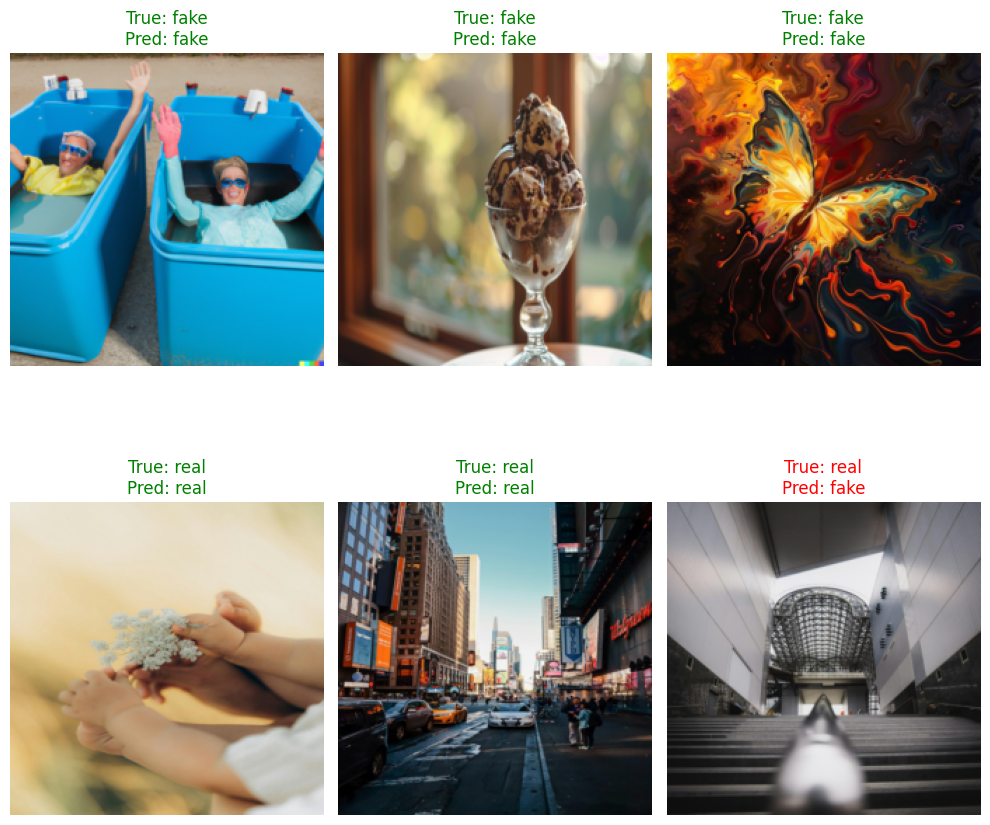

In [24]:
# Get the list of class names ('fake', 'real') from the validation dataset.
class_names = val_dataset.classes

# Visualise predictions made by the trained model
helper_utils.visualize_predictions(trained_model, val_loader, DEVICE, class_names)

#### Test Your FakeFinder on a New Image

Now it's time to put your FakeFinder to the test with a new piece of data. You can upload your own image to see how the model classifies it. This is a great way to test its performance on data it has never seen.

Run the `helper_utils.upload_jpg_widget()` function, which displays a widget for uploading images directly into the workspace. Please note the following:

* You can only upload images that have a `.jpg` extension.
* The file size for the image should not exceed **5 MB**.
* After a successful upload, the image's file path will be displayed. You should copy this path for the next step.
* Once the widget is displayed, you can use it multiple times to upload images; you don't have to re-run the `helper_utils.upload_jpg_widget()` function.

In [25]:
helper_utils.upload_jpg_widget()

FileUpload(value=(), accept='.jpg', description='Upload JPG (Max 5MB)')

Output()

* Set the path to your image (as displayed above).

Alternatively, you can use these images that are already present in the workspace:
> * `image_path = './images/fake/birds_sheep_dog.jpg'`
> * `image_path = './images/fake/car_bus_tram.jpg'`
> * `image_path = './images/fake/person_and_bicycle.jpg'`
> * `image_path = './images/real/eiffel_tower.jpg'`
> * `image_path = './images/real/minar.jpg'`
> * `image_path = './images/real/statue_liberty.jpg'`


* A default path has been set for you, but feel free to change it to a different one.

In [30]:
# EDITABLE CELL:

image_path = './images/fake/birds_sheep_dog.jpg' ### Add your image path here

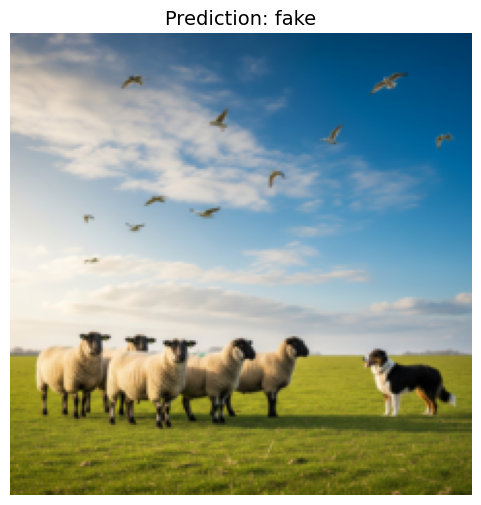

In [31]:
# Display a prediction for the single uploaded image.
helper_utils.make_predictions(trained_model, image_path, DEVICE, class_names)

## Conclusion

Congratulations, AI Explorer! You have successfully completed your second expedition and significantly upgraded your FakeFinder. By masterfully applying transfer learning, you have not only improved your model's performance but also added one of the most practical and powerful techniques in modern AI to your skillset. In this assignment, you successfully loaded a pre-trained MobileNetV3 model, preserved its knowledge by freezing its core layers, and skillfully replaced its classifier to specialize it for your task. You then trained the adapted model and witnessed a dramatic performance increase, achieving a higher validation accuracy in a fraction of the training time compared to your custom built model.

Your journey through these two assignments illustrates a fundamental lesson in applied AI. In the first expedition, you learned the essential principles of building and optimizing a model from scratch. In this second expedition, you learned how to stand on the shoulders of giants by leveraging pre-trained models to solve problems with incredible speed and efficiency. A truly skilled AI practitioner knows when to build from the ground up and when to adapt existing tools. You are now equipped with both skill sets.

Well done on a successful mission. May your future expeditions into the world of AI be even more ambitious and rewarding.